In [1]:
#####################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
###############################################################################################################
# Extract pose features using LFTD method, for each VID (38 VIDs in total)
# DONE
# REDONE when subject 19 eliminated
###############################################################################################################

###############################################################################################################
# 1.) Extract pose features (joint angles) & interpolate them to match number of audio frames
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.651.3386&rep=rep1&type=pdf
# Save after this step.
###############################################################################################################

from geoutils import radToDeg, xyz_to_angles # my custom set of functions
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
from geo import Point

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
audio_frame_cnts = np.load('./../Dataset/'+TE_folder+'/te_frameCnts.npz')['frameCnts'] # number of audio frames for each VID as sorted above

N_JOINT_ANGLES = 12
angles_names = [
    "HeadPitch", "HeadYaw", 
    "LShoulderRoll", "LShoulderPitch", "LElbowRoll", "LElbowYaw",
    "RShoulderRoll", "RShoulderPitch", "RElbowRoll", "RElbowYaw", 
    "HipRoll", "HipPitch"
]
jointID = {     # Mapping: joint names -> position in array as extracted
    'Pelvis'    : 0,
    #'RHip'      : 1,   # not used
    #'LHip'      : 2,   # not used
    #'Spine'     : 7,   # not used
    'Neck'      : 8,
    'Nose'      : 9,
    'HeadTop'   : 10,  
    'LShoulder' : 11,
    'LElbow'    : 12,
    'LWrist'    : 13,
    'RShoulder' : 14,
    'RElbow'    : 15,
    'RWrist'    : 16
}

# For each VID extract LFTD pose angles
for i, VID in enumerate(unique_srt_VIDs):
        
    data = np.load('./../Dataset/LiftFromDeep/' +VID+ '.npz')['joints_3D'].astype(float)
    NUM_FRAMES_ORG = len(data) # number of frames before lin. interpolation
    
#     print NUM_FRAMES_ORG, 2*NUM_FRAMES_ORG-1, audio_frame_cnts[i]
#     print audio_frame_cnts[i] - (2*NUM_FRAMES_ORG-1)
    if audio_frame_cnts[i] != (2*NUM_FRAMES_ORG-1):
        raise ValueError('Audio and pose frames not synchronised!')
    
    joint_angles = np.zeros((NUM_FRAMES_ORG, N_JOINT_ANGLES)) # array of 12 joint angles for each frame, for a given VID

    for frame_num, xyz in enumerate(data): # iterate over frames

        ####################################################################
        # Calculate 12 joint angles, if not possible for this method set NAN (np.nan)
        # xyz[jointID['Pelvis']] gives xyz coordinates of Pelvis joint

        joint_angles[frame_num] = xyz_to_angles(Point(xyz[jointID['HeadTop']]), Point(xyz[jointID['Nose']]), 
                                                   Point(xyz[jointID['Neck']]),    Point(xyz[jointID['Pelvis']]), 
                    Point(xyz[jointID['LShoulder']]), Point(xyz[jointID['LElbow']]), Point(xyz[jointID['LWrist']]), 
                    Point(xyz[jointID['RShoulder']]), Point(xyz[jointID['RElbow']]), Point(xyz[jointID['RWrist']])                  
        )
    
    # Linear interpolation between every pair of original adjacent points
    NUM_FRAMES_NEW = 2*NUM_FRAMES_ORG-1
    interp_joint_angles = np.zeros((NUM_FRAMES_NEW, N_JOINT_ANGLES))
    for j in range(NUM_FRAMES_ORG-1):
        
        # Original points
        interp_joint_angles[2*j] = joint_angles[j]

        # Interpolated points
        interp_joint_angles[2*j+1] = (joint_angles[j] + joint_angles[j+1]) / 2.

    interp_joint_angles[-1] = joint_angles[-1] # add last original point
#     print joint_angles
#     print interp_joint_angles
            
        
    if i == 0:
        PF_nonsmooth = np.copy(interp_joint_angles) # pose features not smoothed
    else:
        PF_nonsmooth = np.concatenate((PF_nonsmooth, interp_joint_angles), axis=0) # pose features not smoothed
    
    print VID
    print "\t#frames before and after lin. interpolation: ", NUM_FRAMES_ORG, " -- ", NUM_FRAMES_NEW
    print "\t", PF_nonsmooth.shape

    
# Save all pose features (sum_i N_Frames_i) x 12: before smoothing, after lin. interpolation
np.savez('./../Dataset/'+TE_folder+'/te_PF_nonsmooth.npz', PF_nonsmooth=PF_nonsmooth)
print "Pose features, shape =", PF_nonsmooth.shape
print "Time taken:", time.time()-st

PID02Task2
	#frames before and after lin. interpolation:  3815  --  7629
	(7629, 12)
PID02Task3
	#frames before and after lin. interpolation:  3205  --  6409
	(14038, 12)
PID05Task2
	#frames before and after lin. interpolation:  3810  --  7619
	(21657, 12)
PID05Task3
	#frames before and after lin. interpolation:  3914  --  7827
	(29484, 12)
PID06Task2
	#frames before and after lin. interpolation:  2947  --  5893
	(35377, 12)
PID06Task3
	#frames before and after lin. interpolation:  3086  --  6171
	(41548, 12)
PID08Task2
	#frames before and after lin. interpolation:  3275  --  6549
	(48097, 12)
PID08Task3
	#frames before and after lin. interpolation:  3118  --  6235
	(54332, 12)
PID09Task2
	#frames before and after lin. interpolation:  3484  --  6967
	(61299, 12)
PID09Task3
	#frames before and after lin. interpolation:  3244  --  6487
	(67786, 12)
PID10Task2
	#frames before and after lin. interpolation:  2458  --  4915
	(72701, 12)
PID10Task3
	#frames before and after lin. interpolation

NameError: name 'st' is not defined

In [7]:
###############################################################################################################
# 2.) Apply low-pass filter (5th order Butterworth, zero-lag) to the non-smooth data, for all VIDs
# Then constrain to robot operating limits
# Save after this step
# DONE
###############################################################################################################
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
from geoutils import degToRad
from postprocessingutils import smoother_LPBF

fc = 6. # cut-off frequency in Hz

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs'] # sorted VIDs
all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']

PF_nonsmooth = np.load('./../Dataset/'+TE_folder+'/te_PF_nonsmooth.npz')['PF_nonsmooth']
PF_smooth_LPBF = np.zeros(PF_nonsmooth.shape)

st = time.time()
for VID in unique_srt_VIDs:
    
    #VID = 'PID20Task2'

    # Range of indices in all_srt_VIDs correspponding to this VID
    rangeI = np.argwhere(all_srt_VIDs == VID)[:,0]
    # Temporal nonsmooth data series for current VID
    PF_nonsmooth_VID = np.copy(PF_nonsmooth[rangeI])
    
    PF_smooth_VID = smoother_LPBF(PF_nonsmooth_VID, fc, constrain=True)
    PF_smooth_LPBF[rangeI] = np.copy(PF_smooth_VID)
    #print PF_smooth[rangeI]
    print VID, " done."
    
# Save all pose features (sum_i N_Frames_i) x 12: after smoothing, after lin. interpolation
np.savez('./../Dataset/'+TE_folder+'/te_PF_smooth_LPBF_' + str(fc) + '.npz', 
         PF_smooth_LPBF=PF_smooth_LPBF, fc=fc)
print "Time taken: ", (time.time()-st)/60., " min"
print "Pose features, shape =", PF_smooth_LPBF.shape

PID02Task2  done.
PID02Task3  done.
PID05Task2  done.
PID05Task3  done.
PID06Task2  done.
PID06Task3  done.
PID08Task2  done.
PID08Task3  done.
PID09Task2  done.
PID09Task3  done.
PID10Task2  done.
PID10Task3  done.
PID11Task2  done.
PID11Task3  done.
PID13Task2  done.
PID13Task3  done.
PID15Task2  done.
PID15Task3  done.
PID16Task2  done.
PID16Task3  done.
PID17Task2  done.
PID17Task3  done.
PID18Task2  done.
PID18Task3  done.
PID20Task2  done.
PID20Task3  done.
PID21Task2  done.
PID21Task3  done.
PID22Task2  done.
PID22Task3  done.
PID23Task2  done.
PID23Task3  done.
PID24Task2  done.
PID24Task3  done.
PID25Task2  done.
PID25Task3  done.
PID26Task2  done.
PID26Task3  done.
Time taken:  0.0393497983615  min
Pose features, shape = (214060, 12)


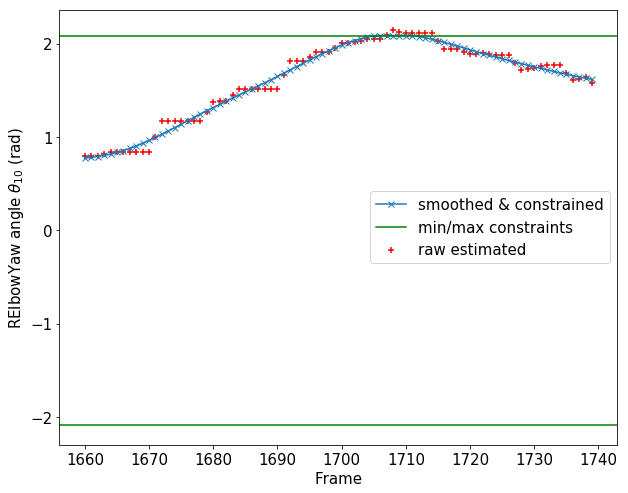

In [16]:
###############################################################################################################
# Plot
###############################################################################################################
import time
import numpy as np
import matplotlib.pyplot as plt
import glob
from geoutils import degToRad

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

VID = 'PID19Task2'
VID = 'PID19Task3' # NO LONGER WORKS FOR THIS SUBJECT - ELIMINATED!
VID = 'PID20Task3'
# VID = 'PID02Task2'
# VID = 'PID18Task2'

TE_folder = 'TrainingExamples_16kHz'
PF_nonsmooth = np.load('./../Dataset/'+TE_folder+'/te_PF_nonsmooth.npz')['PF_nonsmooth']
PF_smooth =    np.load('./../Dataset/'+TE_folder+'/te_PF_smooth_LPBF_4.0.npz')['PF_smooth_LPBF']


all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']
# Range of indices all_srt_VIDs to this VID
rangeI = np.argwhere(all_srt_VIDs == VID)[:,0]
 
PF_nonsmooth_VID   = PF_nonsmooth[rangeI]
PF_smooth_VID      = PF_smooth[rangeI]     # smoothed and constrained

###############################################################################################################

N_JOINT_ANGLES = 12
angles_names = [
    "HeadPitch", "HeadYaw", 
    "LShoulderRoll", "LShoulderPitch", "LElbowRoll", "LElbowYaw",
    "RShoulderRoll", "RShoulderPitch", "RElbowRoll", "RElbowYaw", 
    "HipRoll", "HipPitch"
]

# Robot movement constraints: ordered as     HeadPitch, HeadYaw, 
#                                            LShoulderRoll, LShoulderPitch, LElbowRoll, LElbowYaw,
#                                            RShoulderRoll, RShoulderPitch, RElbowRoll, RElbowYaw, 
#                                            HipRoll, HipPitch
robot_angle_constraints_deg = np.array([
    [-40.5, -119.5,  0.5, -119.5, -89.5, -119.5, -89.5, -119.5,   0.5, -119.5, -29.5, -59.5], # minima of (N_JOINT_ANGLES) of joint angles
    [ 36.5,  119.5, 89.5,  119.5,  -0.5,  119.5,  -0.5,  119.5,  89.5,  119.5,  29.5,  59.5]  # maxima
])
robot_angle_constraints_rad = degToRad(robot_angle_constraints_deg)

###############################################################################################################

# plt.figure(figsize=(15,80))
f3 = np.arange(len(PF_nonsmooth_VID))
x_max_range = 1740
x_min_range = 1660

# for iA in range(N_JOINT_ANGLES-1):
    
iA = 9
PF_cons_smooth_VID = [ min(max(a, robot_angle_constraints_rad[0,iA]), robot_angle_constraints_rad[1,iA]) 
                      for a in PF_smooth_VID[x_min_range:x_max_range, iA]]

#plt.subplot(N_JOINT_ANGLES-1, 1, iA+1)
#plt.figure() # figsize=(15,80)
plt.figure(figsize=(10,8))

plt.scatter(f3[x_min_range:x_max_range], PF_nonsmooth_VID[x_min_range:x_max_range, iA], c='red', marker='+', label='raw estimated')	# measured
#     plt.plot(f3[:x_max_range], PF_smooth_VID[:x_max_range, iA] , 'x-', label='smoothed')				# filtered
plt.plot(f3[x_min_range:x_max_range], PF_cons_smooth_VID , 'x-', label='smoothed & constrained')				# constrained filtered

plt.axhline(y=robot_angle_constraints_rad[0,iA], color='green', label='min/max constraints')	# constraints
plt.axhline(y=robot_angle_constraints_rad[1,iA], color='green')
plt.xlabel("Frame")
plt.ylabel(angles_names[iA] + r' angle $\theta_{10}$ (rad)')
#plt.title(angles_names[iA])
plt.legend()
plt.show()
